# Практика 3: Атака Carlini-Wagner (CW) на модели ИИ
# Выполнил студент: Асатрян Давид Робертовись Группа: ББМО-01-23

**Цель** задания:
Изучить одну из наиболее мощных атак на модели ИИ — атаку Carlini-Wagner (CW). Задача — научиться использовать CW для создания противоречивых примеров и исследовать влияние этой атаки на обученные модели.

# Задачи:
Загрузить ранее обученную модель на датасете MNIST.
Изучить теоретические основы атаки Carlini-Wagner.
Реализовать атаку CW с помощью фреймворка Foolbox.
Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных данных.


Шаг 1. Загрузка обученной модели и данных MNIST

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt


(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('/content/mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9710 - loss: 0.1051
Test accuracy on clean images: 0.9746999740600586


Шаг 2: Установка необходимых библиотек и импорт библиотек

In [7]:
!pip install tensorflow foolbox matplotlib

Шаг 3:Инициализация Foolbox и выбор изображения для атаки

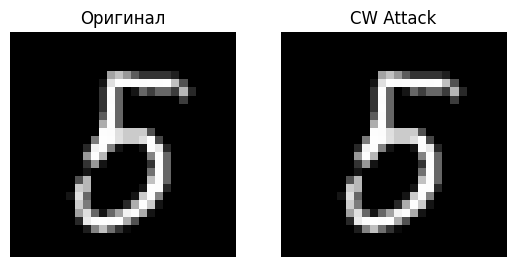

In [8]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Конвертация и выборка
image = tf.convert_to_tensor(test_images[45], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0]) # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64) # Конвертируем в тензор

# Создание и выполнение Carlini-Wagner атаки
attack = fb.attacks.L2CarliniWagnerAttack(steps = 100)
adversarial_image = attack(fmodel, image, label[None], epsilons=0.1)

# Вывод результатов
plt.subplot(1, 2, 1)
plt.title("Оригинал")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("CW Attack")
plt.imshow(adversarial_image[0][0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

Шаг 3: Оценка модели

In [9]:
adversarial_images = []
batch_size = 32

# Обработка изображений пакетами
for i in range(0, len(test_images) // 10, batch_size):

    # Создаем пакет изображений и меток
    batch_images = tf.convert_to_tensor(test_images[i:i + batch_size], dtype=tf.float32)
    batch_labels = np.argmax(test_labels[i:i + batch_size], axis=1)
    batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int64)

    # Проверка размерности
    advs, _, success = attack(fmodel, batch_images, batch_labels, epsilons=0.1)
    adversarial_images.append(advs)

# Конвертация списка в массив с правильной формой
adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:len(adversarial_images)])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0230 - loss: 1.3381 
Accuracy on adversarial examples (CW attack): 0.01953125


Шаг 4: Сравнение результатов

В процессе исследования наблюдается, что точность на стандартных примерах составляет около 97,8%, тогда как на противоречивых она падает до примерно 2,5%. Это исследование демонстрирует, что модель можно легко ввести в заблуждение.